###  Friday 13th October 2023

Alistair Duffey

This notebook:
* finds the 20 year period with gmst = 1.5C under each ssp and ensemble member
* calculates the CO2 concentration at crossing 1.5 under each scenario and esnemble member
* calculates the global mean precip at crossing 1.5 under each ensemble member

We do this only for CESM2, because 
(1) CESM2-WACCM has the ARISE simulations to compare against. 
(2) CESM2-WACCM has a lower climate sensitivity than UKESM, so hopefully will see more of a difference in warming rate through 1.5C between scenarios, since 1.5C happens over a decade later. 

I hope to show that:
(1) CO2 is higher at 1.5C for ssp585 than ssp245 (for faster warming scenarios)
(2) global mean rainfall is lower at 1.5C for ssp585 than ssp245 (for faster warming scenarios)
(3) (hopefully) global mean rainfall at 1.5C is ~linear in the rate of warming through 1.5C, such that we can just draw a straight line through points to get the intercept 

notes:
* SSP534-over scenario has no data before 2040, when it branches from ssp585, so needs to be excluded from the analysis. 

In [2]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
import esmvalcore.preprocessor
import xarray as xr
import xesmf as xe
from tqdm import tqdm
from xmip.preprocessing import rename_cmip6
import matplotlib
import matplotlib.pyplot as plt
import dask
from nc_processing import calc_spatial_mean
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns

def read_in(dir, ocean = False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, engine='netcdf4'))
    return ds

def read_in_ens_mean(dirs, ocean = False):
    """ returns (1) the ensemble mean dataset, and (2) the number of ensemble members """
    
    files = []
    for dir in dirs:
        for x in os.listdir(dir):
            if '.nc' in x:
                files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, concat_dim='ensemble',combine='nested'))
        n_ens = len(ds.ensemble) 
        ds = ds.mean(dim='ensemble')
        ds['number_ens_mems_meaned'] = n_ens
    return ds, n_ens

def get_gmst(ds, var='tas'):
    return calc_spatial_mean(ds[var].mean(dim="time"), lon_name="x", lat_name="y").values


In [3]:
## define inputs



#mods = ['UKESM1-0-LL', 'CESM2-WACCM', 'IPSL-CM6A-LR']
#mods = ['CESM2-WACCM']
mods = ['UKESM1-0-LL']
var = 'co2mass'
table = 'Amon'

model = mods[0]

In [4]:
### test scenario availability

#var = 'tas'
#vars = ['pr', 'tas']
SSP_scens = []
table = 'Amon'
print(var)
folders = glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/*/{m}/ssp*/*/{t}/{v}/*/latest/'.format(m=model, t=table, v=var))
for folder in folders:
    scen = folder.split('/')[8]
    if not scen in SSP_scens:
        SSP_scens.append(scen)

print(SSP_scens)
SSP_scens.remove('ssp534-over')
print(SSP_scens)

co2mass
['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp534-over', 'ssp585']
['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp585']


In [5]:

### first get PI gmst:
def get_gmst(model):
    dir_pi = glob.glob('/badc/cmip6/data/CMIP6/*/*/{}/piControl/r1i*/Amon/tas/*/latest/'.format(model))
    files_pi = os.listdir(dir_pi[0])[0:3] # don't need the full length run
    paths_pi = []
    for x in files_pi:
        paths_pi.append(dir_pi[0]+x)
    da_pi = rename_cmip6(xr.open_mfdataset(paths_pi)).tas.mean(dim='x')
    da_pi = da_pi.weighted(weights=np.cos(np.deg2rad(da_pi.y))).mean(dim='y')
    
    gmst_pi = da_pi.mean(dim='time').values
    print(gmst_pi)
    return gmst_pi

gmst_pi = get_gmst(model)


286.52036529129015


In [6]:
### also get PI value of co2mass:
def get_pi_CO2(model):
    dir_pi = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/piControl/r1i*/Amon/co2mass/*/latest/'.format(m=model))
    files_pi = os.listdir(dir_pi[0])[0:3] # don't need the full length run
    paths_pi = []
    for x in files_pi:
        paths_pi.append(dir_pi[0]+x)
    da_pi = rename_cmip6(xr.open_mfdataset(paths_pi))[var]
    
    gmst_pi = da_pi.mean(dim='time').values
    print(gmst_pi)
    return gmst_pi

CO2_pi = get_pi_CO2(model)


2214839300000000.0


In [7]:
### now get non-integer crossing year:


def get_var_at_crit_T(mod, var, table, scen, ens_mem, crit_warming=2, window_length=21):
    """ produce a spatial nc file, with map of mean values during window when 
    model and scen pass a gmst temperature threshold crit_temp
     """
    
    folder_tas = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/{e}/Amon/tas/*/latest/'.format(
            m=mod, s=scen, e=ens_mem))[0]
    folder_tas_hist = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/{e}/Amon/tas/*/latest/'.format(
            m=mod, s=scen, e=ens_mem))[0]
    
    folder_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/{e}/{t}/{v}/*/latest/'.format(
            m=mod, s=scen, t=table, v=var, e=ens_mem))[0]
    folder_var_hist = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/historical/{e}/{t}/{v}/*/latest/'.format(
            m=mod, s=scen, t=table, v=var, e=ens_mem))[0]
    
    crit_temp = gmst_pi + crit_warming
    
    ds = xr.concat([read_in(folder_tas_hist), read_in(folder_tas)], dim='time')
    #ds = read_in(folder_tas)
    ds = ds.sel(time=slice('1990', '2150'))
    ds_annual_spatial_mean = calc_spatial_mean(ds.tas, lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': ds_annual_spatial_mean.year.values,
                           'gmst': ds_annual_spatial_mean.values})

    df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()

    
    ds = xr.concat([read_in(folder_var_hist), read_in(folder_var)], dim='time')
    #ds = read_in(folder_tas)
    
    
    ds = ds.sel(time=slice('1990', '2150'))
    
    if var == 'co2mass':
        ds_annual_spatial_mean = ds[var].groupby("time.year").mean(dim="time")
        ds_annual_spatial_mean = ds_annual_spatial_mean - CO2_pi
    else:
        ds_annual_spatial_mean = calc_spatial_mean(ds[var], lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")

    df[var] = ds_annual_spatial_mean.values
    name = str(var+'_rolling')
    df[name] = df[var].rolling(window=window_length, center=True).mean()

    # also add column for rate of change of T:
    gmst_rolling_dTdt = np.diff(df['gmst_rolling'])
    
    
    ## now calculate crossing year:
    crossing_year = np.interp(crit_temp, df['gmst_rolling'], df['Year'])
    crossing_var = np.interp(crossing_year, df['Year'], df[name])
    crossing_rate = np.interp(crossing_year, df['Year'][:-1], gmst_rolling_dTdt)


    gmst_window_df = df[df['Year'] > int(crossing_year - 10/2)]
    gmst_window_df = gmst_window_df[gmst_window_df['Year'] < int(crossing_year + 10/2)]
    crossing_rate_2 = stats.linregress(gmst_window_df['Year'], gmst_window_df['gmst']).slope
    
    out_dict = {'Scenario':scen,
                'Ensemble_member':ens_mem,
                'Model':mod,
                'Crossing_year_{}'.format(crit_warming):crossing_year,
                '{}_at_crossing_year'.format(var):crossing_var,
                'Warming_rate_at_crossing_year':crossing_rate,
                'Warming_rate_at_crossing_year_2':crossing_rate_2}
    return out_dict, df

In [8]:
out_dict, df = get_var_at_crit_T(mod=model, var=var, table='Amon', 
                       scen='ssp245', ens_mem='r1i1p1f2', crit_warming=1.5, window_length=15)

In [9]:
out_dict

{'Scenario': 'ssp245',
 'Ensemble_member': 'r1i1p1f2',
 'Model': 'UKESM1-0-LL',
 'Crossing_year_1.5': 2023.0989202886146,
 'co2mass_at_crossing_year': 1084898997198720.4,
 'Warming_rate_at_crossing_year': 0.0599932263715558,
 'Warming_rate_at_crossing_year_2': 0.05913074828178632}

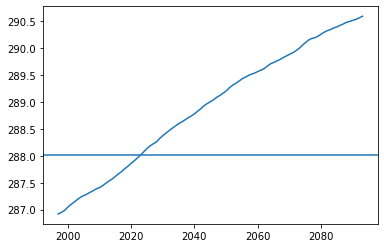

In [10]:
plt.plot(df['Year'], df['gmst_rolling'])
plt.axhline(gmst_pi + 1.5)

In [11]:
crossing_year = np.interp(gmst_pi + 1.5, df['gmst_rolling'], df['Year'])
crossing_year

2023.0989202886146

In [12]:
# cool, now run across all the scenarios and ensemble members:

out_dicts = []
df_list = []
scen_list = []

thresh = 1.5

for scen in SSP_scens:
    ens_mems = []
    for path in glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/Amon/{v}/*/latest/'.format(
        m=model, s=scen, v=var)):
        if os.path.isdir(path.replace(var, 'tas').replace('gm', 'gn')):
            if os.path.isdir(path.replace(scen, 'historical').replace('ScenarioMIP', 'CMIP')):
                if os.path.isdir(path.replace(scen, 'historical').replace('ScenarioMIP', 'CMIP').replace(var, 'tas').replace('gm', 'gn')):
                          
                    ens_mems.append(path.split('/')[9])
    print(scen)
    print(ens_mems)

    for ens_mem in ens_mems:
        if scen == 'ssp534-over':
            print(print('not running :'+ ens_mem))
            pass
        else:
            print('running :'+ ens_mem)
            out_dict, df = get_var_at_crit_T(mod=model, var=var, table='Amon', 
                               scen=scen, ens_mem=ens_mem, crit_warming=thresh, window_length=20)
            
            out_dicts.append(out_dict)
            df_list.append(df) 
            scen_list.append(scen)


ssp119
['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']
running :r1i1p1f2
running :r2i1p1f2
running :r3i1p1f2
running :r4i1p1f2
running :r8i1p1f2
ssp126
['r10i1p1f2', 'r11i1p1f2', 'r12i1p1f2', 'r16i1p1f2', 'r17i1p1f2', 'r18i1p1f2', 'r19i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2', 'r9i1p1f2']
running :r10i1p1f2
running :r11i1p1f2
running :r12i1p1f2
running :r16i1p1f2
running :r17i1p1f2
running :r18i1p1f2
running :r19i1p1f2
running :r1i1p1f2
running :r2i1p1f2
running :r3i1p1f2
running :r4i1p1f2
running :r8i1p1f2
running :r9i1p1f2
ssp245
['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2', 'r13i1p1f2']
running :r1i1p1f2
running :r2i1p1f2
running :r3i1p1f2
running :r4i1p1f2
running :r8i1p1f2
running :r13i1p1f2
ssp370
['r10i1p1f2', 'r11i1p1f2', 'r12i1p1f2', 'r16i1p1f2', 'r17i1p1f2', 'r18i1p1f2', 'r19i1p1f2', 'r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2', 'r9i1p1f2']
running :r10i1p1f2
running :r11i1p1f2
running :r12i1p1f2
running :r16

In [24]:
df

,Year,gmst,gmst_rolling,co2mass,co2mass_rolling
0,1990,286.793681,NaN,5.436053e+14,NaN
1,1991,286.630387,NaN,5.526070e+14,NaN
2,1992,286.262503,NaN,5.598644e+14,NaN
3,1993,286.458655,NaN,5.668658e+14,NaN
4,1994,286.582321,NaN,5.772523e+14,NaN
...,...,...,...,...,...
106,2096,293.595012,NaN,6.202495e+15,NaN
107,2097,293.400000,NaN,6.309180e+15,NaN
108,2098,293.625151,NaN,6.415607e+15,NaN
109,2099,293.730038,NaN,6.522037e+15,NaN


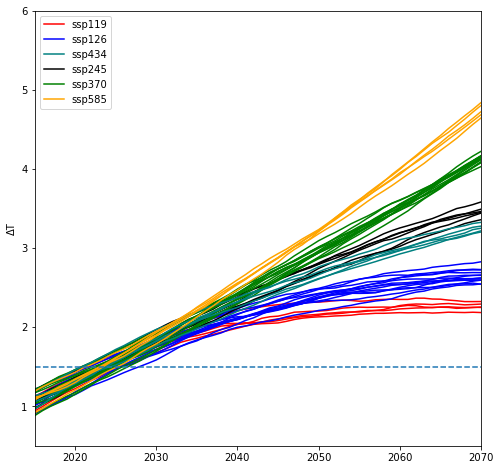

In [23]:
colors_dict = {'ssp119':'Red',
             'ssp126':'Blue',
             'ssp434':'Teal',
             'ssp245':'Black',
             #'ssp534-over':'Purple',
             'ssp370':'Green',
             'ssp585':'Orange'}

fig, ax = plt.subplots(figsize=(8, 8))
i=0
for df in df_list:
    plt.plot(df['Year'], df['gmst_rolling']-gmst_pi, color=colors_dict[scen_list[i]])
    i=i+1
for entry in colors_dict:
    plt.plot([], [], color = colors_dict[entry], label=entry)
plt.xlim(2015, 2070)
plt.legend()
plt.axhline(thresh, ls='--')
plt.ylabel('\u0394T')
plt.ylim(0.5, 6)
#plt.savefig('Figures/T_projections_{}'.format(model))
#plt.title('UKESM1 SSP temperature projections')
plt.savefig('Figures/Temperature_projections_SSPs_{}.jpg'.format(model), dpi=400)

LinregressResult(slope=696613279181775.1, intercept=1052821624927497.4, rvalue=0.15143042282346986, pvalue=0.3095940807650218, stderr=677852084364443.8, intercept_stderr=32451563057511.33)


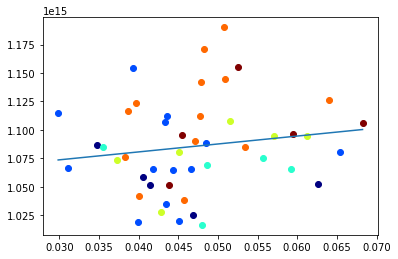

In [25]:
rates = []
prs = []
scenarios = []
members = []
crossing_years = []


ordered_ssps = {'ssp119':1,
                'ssp126':2,
                'ssp434':3,
                'ssp245':4,
                'ssp370':5,
                'ssp585':6}

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(ordered_ssps)))

colors_dict = dict(zip(ordered_ssps, colors))



for out_dict in out_dicts:
    plt.scatter(out_dict['Warming_rate_at_crossing_year'], out_dict['{}_at_crossing_year'.format(var)], color=colors_dict[out_dict['Scenario']])
    rates.append(out_dict['Warming_rate_at_crossing_year'])
    prs.append(out_dict['{}_at_crossing_year'.format(var)])
    scenarios.append(out_dict['Scenario'])
    members.append(out_dict['Ensemble_member'])
    crossing_years.append(out_dict['Crossing_year_{}'.format(thresh)])
    
#plt.legend()
df = pd.DataFrame({'Rate':rates,
                   '{}'.format(var):prs,
                   'Scenario':scenarios,
                   'Ensemble_member':members,
                   'Crossing_year_{}'.format(thresh):crossing_years})

df['Order'] = df['Scenario'].map(ordered_ssps)
df = df.sort_values('Order')
df.to_csv('int_outs/{}_at_crit_temp.csv'.format(var))


x, y = df['Rate'], df['{}'.format(var)]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
print(stats.linregress(x, y))


In [140]:
# reload df if kernel is dead:
df = pd.read_csv('{}_at_crit_temp.csv'.format(var))

In [26]:
df

,Rate,co2mass,Scenario,Ensemble_member,Crossing_year_1.5,Order
0,0.040502,1.058738e+15,ssp119,r1i1p1f2,2023.695000,1
1,0.034760,1.086817e+15,ssp119,r2i1p1f2,2025.503896,1
2,0.041458,1.051398e+15,ssp119,r3i1p1f2,2023.242546,1
3,0.062663,1.052099e+15,ssp119,r4i1p1f2,2023.285725,1
4,0.046890,1.025539e+15,ssp119,r8i1p1f2,2021.704142,1
17,0.044348,1.064733e+15,ssp126,r9i1p1f2,2023.214836,2
16,0.043474,1.035294e+15,ssp126,r8i1p1f2,2021.724566,2
15,0.048489,1.088666e+15,ssp126,r4i1p1f2,2024.432966,2
14,0.043332,1.106801e+15,ssp126,r3i1p1f2,2025.366135,2
13,0.039280,1.154172e+15,ssp126,r2i1p1f2,2027.878316,2


LinregressResult(slope=433713666527880.3, intercept=1063089655062388.6, rvalue=0.09417977204653634, pvalue=0.6205806642747951, stderr=866426655497671.0, intercept_stderr=41965161071262.03)


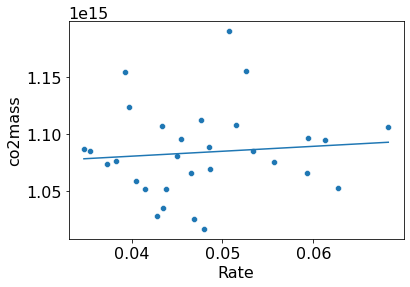

In [141]:
### repeat with just ensemble members shared by all scenarios:
shared_ens_mems = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']

df_shared = df[df['Ensemble_member'].isin(shared_ens_mems)]

sns.scatterplot(data=df_shared, x='Rate', y='co2mass')
x, y = df_shared['Rate'], df_shared['{}'.format(var)]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
print(stats.linregress(x, y))

<AxesSubplot:xlabel='Scenario', ylabel='co2mass'>

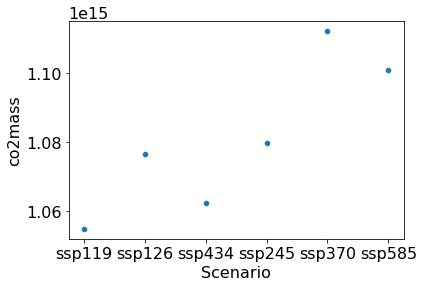

In [142]:
df_grouped = df.groupby('Scenario').mean().sort_values('Order')
sns.scatterplot(data=df_grouped, x='Scenario', y='co2mass')


LinregressResult(slope=2258728132246045.5, intercept=972705096279065.0, rvalue=0.3811293856188785, pvalue=0.4559872742587729, stderr=2739546297155595.0, intercept_stderr=131839960764960.9)


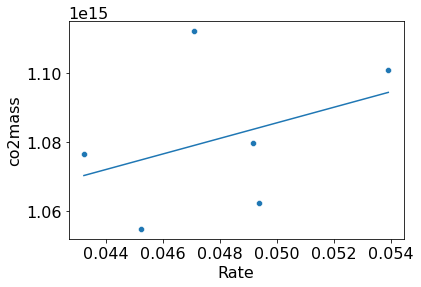

In [143]:
df_grouped = df.groupby('Scenario').mean().sort_values('Order')
sns.scatterplot(data=df_grouped, x='Rate', y='co2mass')
x, y = df_grouped['Rate'], df_grouped['{}'.format(var)]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
lr = stats.linregress(x, y)
print(lr)

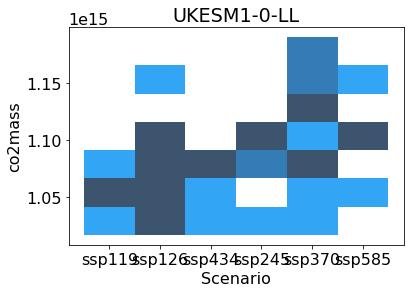

In [144]:
sns.histplot(data=df, x='Scenario', y='{}'.format(var))
plt.title('{}'.format(model))
plt.savefig('Figures/out_{m}_{v}.jpg'.format(m=model, v=var), dpi=400)

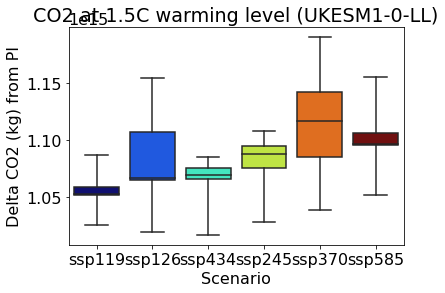

In [145]:
sns.boxplot(data=df, x='Scenario', y='{}'.format(var),
            palette=colors_dict,
           whis=[0, 100])
plt.title('CO2 at {t}C warming level ({m})'.format(t=thresh, m=model))
plt.ylabel('Delta CO2 (kg) from PI')
plt.savefig('Figures/out_boxes_{m}_{v}_{t}C.jpg'.format(m=model, v=var, t=thresh), dpi=400)

LinregressResult(slope=69.66132791817799, intercept=1052.8216249274974, rvalue=0.15143042282347088, pvalue=0.30959408076501843, stderr=67.78520843644436, intercept_stderr=32.451563057511294)


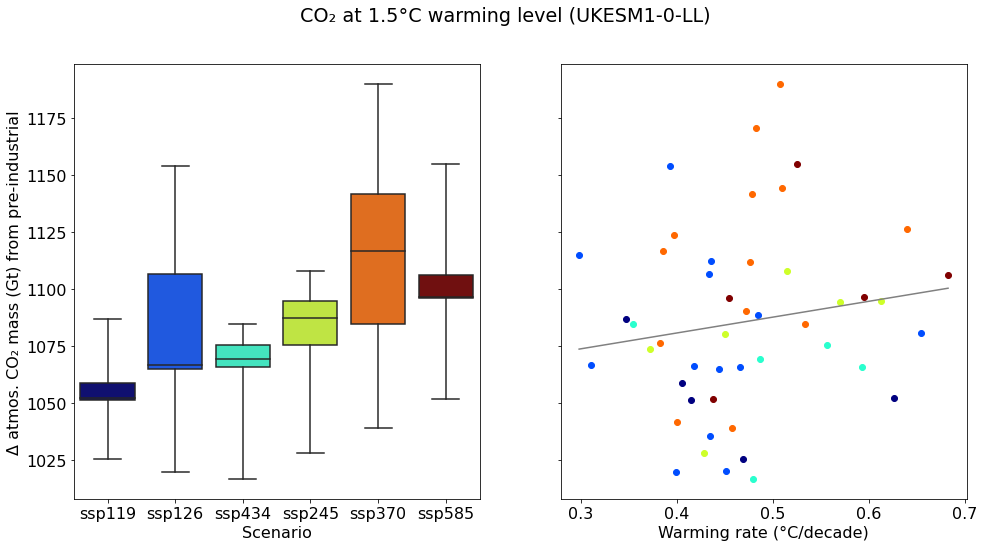

In [146]:
#### nice final figure 
matplotlib.rcParams.update({'font.size': 16})

unit_conversion = 1/10**12
rate_conversion=10
df['co2mass_Gt'] = df['co2mass']*unit_conversion
df['Rate_CperDecade'] = df['Rate']*rate_conversion


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), sharey=True)

ax1 = axes[0]
sns.boxplot(ax=ax1,
            data=df, x='Scenario', y='co2mass_Gt',
            palette=colors_dict,
           whis=[0, 100])
ax1.set_ylabel('\u0394 atmos. CO\u2082 mass (Gt) from pre-industrial')


ax2 = axes[1]

for out_dict in out_dicts:
    ax2.scatter(out_dict['Warming_rate_at_crossing_year']*rate_conversion, 
                out_dict['{}_at_crossing_year'.format(var)]*unit_conversion, 
                color=colors_dict[out_dict['Scenario']])

x, y = df['Rate_CperDecade'], df['co2mass_Gt']
ax2.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='gray')
print(stats.linregress(x, y))
ax2.set_xlabel('Warming rate (°C/decade)')

plt.suptitle('CO\u2082 at {t}°C warming level ({m})'.format(t=thresh, m=model))
plt.savefig('Figures/Main_out_boxes_and_scatter_{m}_{v}_{t}C.jpg'.format(m=model, v=var, t=thresh), dpi=400)